In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
# mounting google drive
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


Define TPU usage

In [ ]:
import tensorflow as tf
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(TPU)
except ValueError:
    tpu_strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', tpu_strategy.num_replicas_in_sync)

Number of replicas: 1


Load Train and Test data

In [ ]:
train_dt = pd.read_csv('train.csv')
test_dt = pd.read_csv('test.csv')

In [ ]:
train_dt.shape, test_dt.shape

((12120, 6), (5195, 5))

In [ ]:
train_dt.columns

Index(['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'], dtype='object')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Plot the bar chart based on given classification

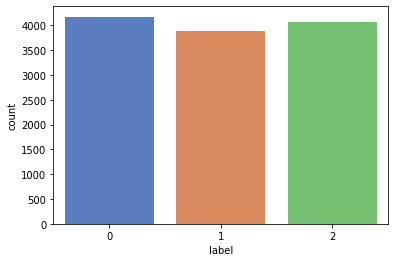

Number of entailment:  4176
Number of neutral:  4064
Number of contradiction:  3880


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

y = train_dt['label']
ax = sns.countplot(y, label="Count", palette="muted")
entailment, neutral, contradiction = y.value_counts()
plt.show()
print('Number of entailment: ', entailment)
print('Number of neutral: ', neutral)
print('Number of contradiction: ', contradiction)

In [ ]:
train_dt.groupby(['language']).count()

,id,premise,hypothesis,lang_abv,label
language,,,,,
Arabic,401,401,401,401,401
Bulgarian,342,342,342,342,342
Chinese,411,411,411,411,411
English,6870,6870,6870,6870,6870
French,390,390,390,390,390
German,351,351,351,351,351
Greek,372,372,372,372,372
Hindi,374,374,374,374,374
Russian,376,376,376,376,376


Bar chart based on the different languages

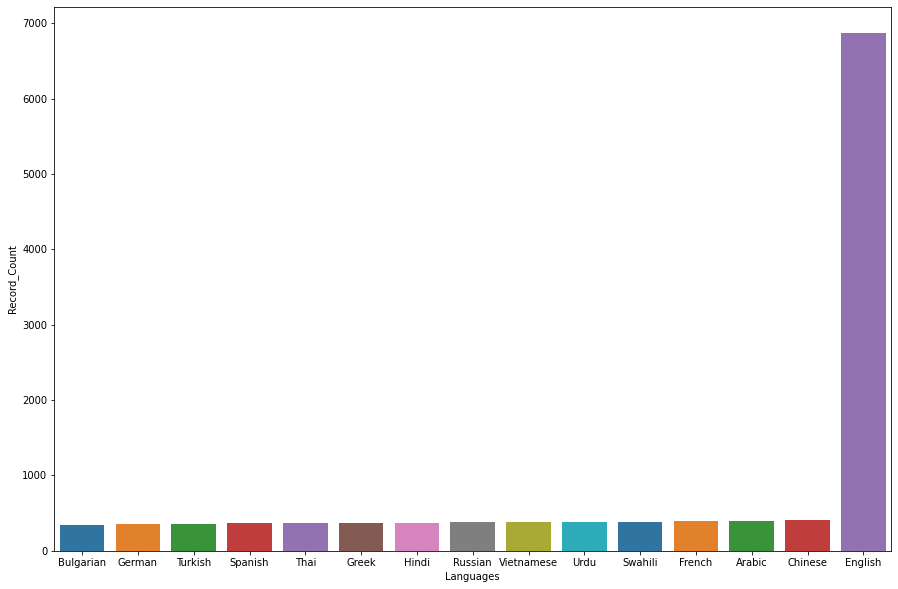

In [ ]:
data = train_dt.groupby(['language']).count()
given_data = pd.DataFrame()
given_data['Languages'] = data.index
given_data['Record_Count']= data['lang_abv'].values
plt.figure(figsize=(15,10))
sns.barplot(data=given_data,x="Languages",y="Record_Count", order=given_data.sort_values('Record_Count').Languages,palette="tab10")


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.6 MB/s 
     |████████████████████████████████| 182 kB 88.0 MB/s 
     |████████████████████████████████| 7.6 MB 71.2 MB/s 


Ref: https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7

Using the mDeBERTa model that can perform natural language inference and capable of handle 100 languages suitable for mulitilingual zero-shot classification.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

Display combination of premise and hypothesis

In [ ]:
train_dt[['premise','hypothesis']].values

array([['and these comments were considered in formulating the interim rules.',
        'The rules developed in the interim were put together with these comments in mind.'],
       ['These are issues that we wrestle with in practice groups of law firms, she said. ',
        'Practice groups are not permitted to work on these issues.'],
       ["Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.",
        "J'essayais d'accomplir quelque chose."],
       ...,
       ["The important thing is to realize that it's way past time to move it.",
        'It cannot be moved, now or ever.'],
       ['At the west end is a detailed model of the whole temple complex.',
        'The model temple complex is at the east end.'],
       ['For himself he chose Atat??rk, or Father of the Turks.',
        'Ataturk was the father of the Turkish nation.']], dtype=object)

Display the usage of tokenization

In [ ]:
data = "Practice groups are not permitted to work on these issues."
tokenizer.convert_tokens_to_ids(list(tokenizer.tokenize(data)))

[56125, 36059, 419, 777, 394, 84721, 289, 2405, 352, 260, 3825, 17983, 261]

Find the maximum size of each column

In [ ]:
train_dt.astype(str).apply(lambda s: s.str.len()).max()

id             10
premise       967
hypothesis    276
lang_abv        2
language       10
label           1
dtype: int64

Verifying the model with an example data.

In [ ]:
import torch
device = torch.device("cpu")

In [ ]:
cl_model = AutoModelForSequenceClassification.from_pretrained(model_name)

ex_premise = "These are issues that we wrestle with in practice groups of law firms, she said."
ex_hypothesis = "Practice groups are not permitted to work on these issues."

ex_input = tokenizer(ex_premise, ex_hypothesis, truncation=True, return_tensors="pt")
y = cl_model(ex_input["input_ids"].to(device))  # cpu
ex_prediction = torch.softmax(y["logits"][0], -1).tolist()
ex_label_names = ["entailment", "neutral", "contradiction"]
ex_prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(ex_prediction, ex_label_names)}
print("Prediction for the given example: ",ex_prediction)

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

Prediction for the given example:  {'entailment': 0.0, 'neutral': 3.1, 'contradiction': 96.8}


Combining premise and hypothesis columns data to create a list

In [ ]:
train_data = train_dt[['premise','hypothesis']].values.tolist()
test_data = test_dt[['premise','hypothesis']].values.tolist()

Considering max length of premise and Hypothesis

In [ ]:

max_len = 100

train_encode = tokenizer.batch_encode_plus(train_data, pad_to_max_length=True, max_length=max_len,truncation=True)
test_encode = tokenizer.batch_encode_plus(test_data, pad_to_max_length=True, max_length=max_len,truncation=True)

Prepare Train Data

In [ ]:
train_inp=tf.convert_to_tensor(train_encode['input_ids'],dtype=tf.int32)
train_att=tf.convert_to_tensor(train_encode['attention_mask'],dtype=tf.int32)
train={'input_word_ids':train_inp,'input_mask':train_att}

Prepare Test Data

In [ ]:
test_inp=tf.convert_to_tensor(test_encode['input_ids'],dtype=tf.int32)
test_att=tf.convert_to_tensor(test_encode['attention_mask'],dtype=tf.int32)
test={'input_word_ids':test_inp,'input_mask':test_att}

Use TPU strategy to use the mDeBERTa model

In [ ]:
from transformers import TFAutoModel

with tpu_strategy.scope():
    input_ids = tf.keras.Input(shape = (100,), dtype = tf.int32,name='input_word_ids') 
    input_mask=tf.keras.Input(shape=(100,),dtype=tf.int32,name='input_mask')    
    mDeBERTa = TFAutoModel.from_pretrained(model_name,from_pt=True)
    mDeBERTa = mDeBERTa([input_ids,input_mask])[0]
    output = tf.keras.layers.GlobalAveragePooling1D()(mDeBERTa)
    output = tf.keras.layers.Dense(3, activation = 'softmax')(output)
    mde_model = tf.keras.Model(inputs = [input_ids,input_mask], outputs = output)
    

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDebertaV2Model: ['pooler.dense.weight', 'classifier.weight', 'deberta.embeddings.position_ids', 'pooler.dense.bias', 'classifier.bias']
- This IS expected if you are initializing TFDebertaV2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDebertaV2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDebertaV2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


Compile the Model and its summary

In [ ]:
mde_model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-5), 
                  loss = 'sparse_categorical_crossentropy', 
                  metrics = ['accuracy']) 
mde_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 tf_deberta_v2_model (TFDeberta  TFBaseModelOutput(l  278218752  ['input_word_ids[0][0]',         
 V2Model)                       ast_hidden_state=(N               'input_mask[0][0]']             
                                one, 100, 768),                                                   
                                 hidden_states=None                                           

Define Early Stopping

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

Compile the Model

In [ ]:
mde_history = mde_model.fit(train,train_dt.label,validation_split = 0.2,epochs=6,batch_size=16*tpu_strategy.num_replicas_in_sync,callbacks=[early_stop],verbose=1)


Epoch 1/6
606/606 [==============================] - 346s 551ms/step - loss: 0.4680 - accuracy: 0.8456 - val_loss: 0.4025 - val_accuracy: 0.8667
Epoch 2/6
606/606 [==============================] - 328s 541ms/step - loss: 0.2664 - accuracy: 0.9146 - val_loss: 0.4499 - val_accuracy: 0.8647
Epoch 3/6
606/606 [==============================] - 328s 541ms/step - loss: 0.1598 - accuracy: 0.9512 - val_loss: 0.5311 - val_accuracy: 0.8593
Epoch 4/6
606/606 [==============================] - 328s 541ms/step - loss: 0.0970 - accuracy: 0.9706 - val_loss: 0.6018 - val_accuracy: 0.8601
Epoch 5/6
606/606 [==============================] - 328s 541ms/step - loss: 0.0672 - accuracy: 0.9817 - val_loss: 0.6703 - val_accuracy: 0.8523
Epoch 6/6
606/606 [==============================] - 328s 542ms/step - loss: 0.0496 - accuracy: 0.9857 - val_loss: 0.7463 - val_accuracy: 0.8535


Prdict the model

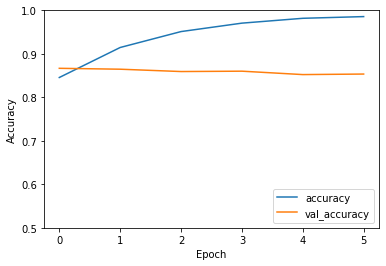

In [ ]:
plt.plot(mde_history.history['accuracy'], label='accuracy')
plt.plot(mde_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_pred=[np.argmax(i) for i in mde_model.predict(test)]

163/163 [==============================] - 48s 265ms/step


Classification with count

In [ ]:
pd.DataFrame(test_pred).value_counts()

0    1874
2    1714
1    1607
dtype: int64

In [ ]:
pd.DataFrame({'id':test_dt.id,
'prediction':test_pred}).to_csv('submission.csv',index=False)